# Introduction

<center><img src="https://i.imgur.com/9hLRsjZ.jpg" height=400></center>

This dataset was scraped from [nextspaceflight.com](https://nextspaceflight.com/launches/past/?page=1) and includes all the space missions since the beginning of Space Race between the USA and the Soviet Union in 1957!
It is very interesting to see how the space industry changed over the years. Are there more missions launched nowadays than during the famous Cold War? How do financial aspects look today, having more 'players' and constantly improved technology?

### Packages & Statements

In [5]:
%pip install iso3166

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from iso3166 import countries
from datetime import datetime, timedelta
import calendar

### Notebook Presentation

In [8]:
pd.options.display.float_format = '{:,.2f}'.format

### Loading the Data

In [10]:
df_data = pd.read_csv('./Data/imported_data/mission_launches.csv')

# Preliminary Data Exploration

In [12]:
print(f'Dataset rows: {df_data.shape[0]}\nDataset columns: {df_data.shape[1]}\n')
df_data.info()
df_data.head()

Dataset rows: 4324
Dataset columns: 9

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    4324 non-null   int64 
 1   Unnamed: 0      4324 non-null   int64 
 2   Organisation    4324 non-null   object
 3   Location        4324 non-null   object
 4   Date            4324 non-null   object
 5   Detail          4324 non-null   object
 6   Rocket_Status   4324 non-null   object
 7   Price           964 non-null    object
 8   Mission_Status  4324 non-null   object
dtypes: int64(2), object(7)
memory usage: 304.2+ KB


Unnamed: 0.1  Unnamed: 0 Organisation  \
0             0           0       SpaceX   
1             1           1         CASC   
2             2           2       SpaceX   
3             3           3    Roscosmos   
4             4           4          ULA   

                                            Location  \
0         LC-39A, Kennedy Space Center, Florida, USA   
1  Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...   
2                      Pad A, Boca Chica, Texas, USA   
3       Site 200/39, Baikonur Cosmodrome, Kazakhstan   
4           SLC-41, Cape Canaveral AFS, Florida, USA   

                         Date                                        Detail  \
0  Fri Aug 07, 2020 05:12 UTC  Falcon 9 Block 5 | Starlink V1 L9 & BlackSky   
1  Thu Aug 06, 2020 04:01 UTC           Long March 2D | Gaofen-9 04 & Q-SAT   
2  Tue Aug 04, 2020 23:57 UTC            Starship Prototype | 150 Meter Hop   
3  Thu Jul 30, 2020 21:25 UTC  Proton-M/Briz-M | Ekspress-80 & Ekspress-103   
4  Thu Jul 30, 2020 11:50 UTC                    Atlas V 541 | Perseverance   

  Rocket_Status  Price Mission_Status  
0  StatusActive   50.0        Success  
1  StatusActive  29.75        Success  
2  StatusActive    NaN        Success  
3  StatusActive   65.0        Success  
4  StatusActive  145.0        Success

## Data Cleaning - Data Types, Missing Values, Duplicates,

Consider removing columns containing junk data.

In [15]:
df_data['Date'] = pd.to_datetime(df_data['Date'].str.split(' UTC').str[0], utc=True, format='mixed', infer_datetime_format=True).dt.tz_convert('Europe/London')
df_data['Date'] = df_data['Date'].dt.date

df_data['Price'] = pd.to_numeric(df_data['Price'].astype(str).str.replace(",", ""), errors='coerce')

/tmp/ipykernel_478/1038516006.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_data['Date'] = pd.to_datetime(df_data['Date'].str.split(' UTC').str[0], utc=True, format='mixed', infer_datetime_format=True).dt.tz_convert('Europe/London')


In [16]:
# Deleting useless columns
df_data.drop(columns=['Unnamed: 0.1','Unnamed: 0'],inplace=True)

In [17]:
print(f'Are there any duplicates? {df_data.duplicated().values.any()}')
print(f'Are there any missing values? {df_data.isna().values.any()}') # Empty cells in Price column

Are there any duplicates? True
Are there any missing values? True


In [18]:
# Duplicates removal
df_data_duplicated = df_data[df_data.duplicated()]
df_data_duplicated
df_data = df_data.drop_duplicates()
print(f'Are there any duplicates? {df_data.duplicated().values.any()}')

Are there any duplicates? False


In [19]:
df_data.Date = pd.to_datetime(df_data.Date)
df_data['year'] = df_data['Date'].dt.year

In [20]:
# Cleaned dataset sample
df_data.sample(5)

Organisation                                           Location  \
408   Arianespace  ELV-1 (SLV), Guiana Space Centre, French Guian...   
3283    RVSN USSR             Site 43/3, Plesetsk Cosmodrome, Russia   
3487    RVSN USSR            Site 133/3, Plesetsk Cosmodrome, Russia   
2928    RVSN USSR         Site 31/6, Baikonur Cosmodrome, Kazakhstan   
4044    RVSN USSR          Site 1/5, Baikonur Cosmodrome, Kazakhstan   

           Date                            Detail  Rocket_Status  Price  \
408  2016-09-16  Vega | PeruSat-1 and SkySats 4-7   StatusActive  37.00   
3283 1971-12-10              Voskhod | Cosmos 464  StatusRetired    NaN   
3487 1970-02-27     Cosmos-2I (63SM) | Cosmos 324  StatusRetired    NaN   
2928 1975-05-28              Voskhod | Cosmos 740  StatusRetired    NaN   
4044 1964-04-20       Molniya | E-6 n†­5 (Luna 5)  StatusRetired    NaN   

     Mission_Status  year  
408         Success  2016  
3283        Success  1971  
3487        Success  1970  
2928        Success  1975  
4044        Failure  1964

 # Data Exploration and Analysis

## Number of Launches per Company

Below we can see a chart presenting number of launches for top 20 organisations(by launch count) from imported dataset.
Surprisingly or not - the gap between the leader and remaining organisations is pretty huge. This is, however, a count for all launches including failed missions - let's get deeper into it.

In [23]:
miss_per_org = df_data.groupby('Organisation', as_index=False).agg({'Mission_Status':'count'}).sort_values(by='Mission_Status', ascending=False)
miss_per_org.head(2)

Organisation  Mission_Status
40    RVSN USSR            1777
3   Arianespace             279

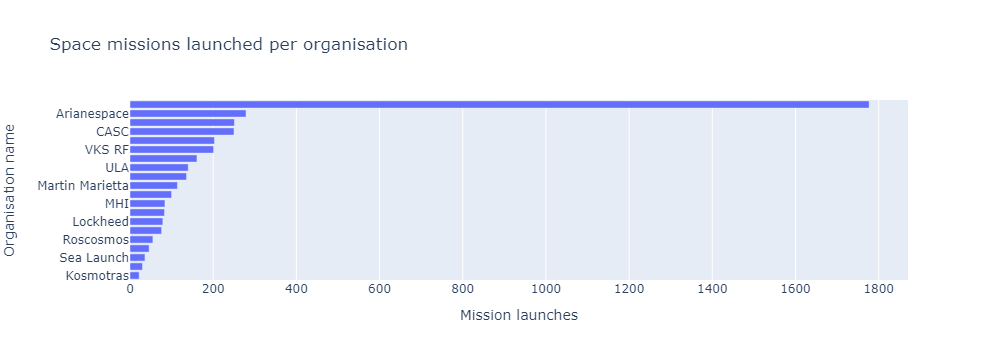

In [24]:
top20_org = miss_per_org.nlargest(20,'Mission_Status')
bar = px.bar(x=top20_org['Mission_Status'],
       y=top20_org['Organisation'],
       orientation='h',
       title='Space missions launched per organisation',
             barmode='group')
bar.update_layout(xaxis_title='Mission launches',
                 yaxis_title='Organisation name',
                 yaxis={'categoryorder':'total ascending'})


Yearly launches by the top organisations:

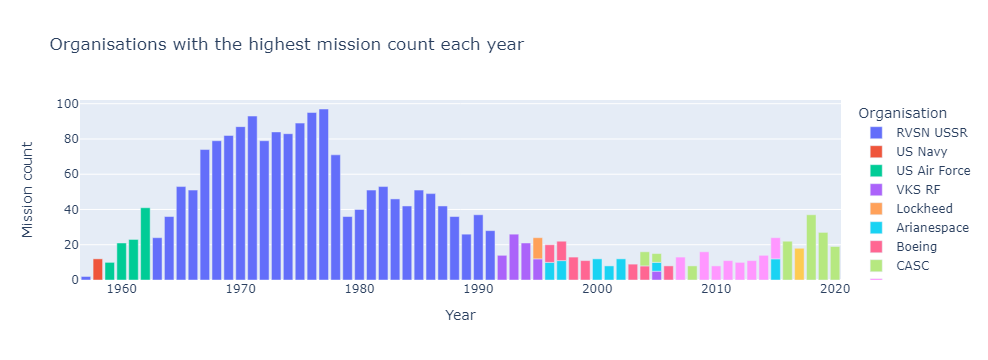

In [26]:
launch_per_org = df_data.groupby(['year','Organisation'],as_index=False).agg({'Mission_Status':'count'}).sort_values(by=['year','Mission_Status'])
launch_top_org = launch_per_org.groupby('year',as_index=False).agg({'Mission_Status':'max'}).sort_values(by='year')
launch_top_org = launch_top_org.merge(launch_per_org,on=['year','Mission_Status'],how='left')
px.bar(launch_top_org,
       x='year',
       y='Mission_Status',
       color='Organisation',
       title='Organisations with the highest mission count each year',
       labels={'Mission_Status':'Mission count','year':'Year'})

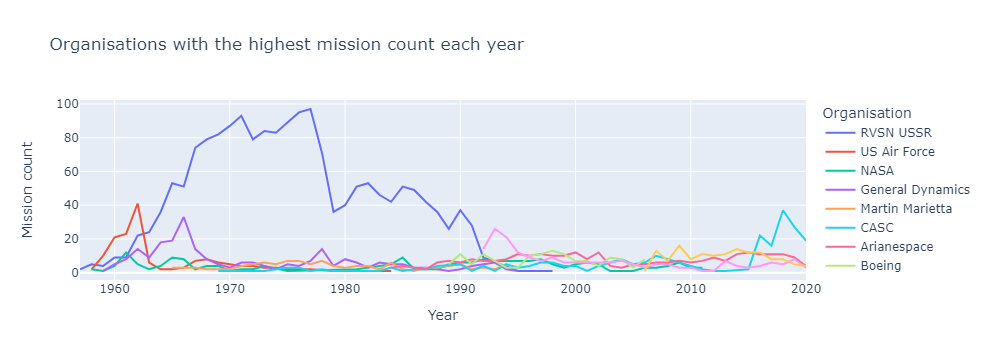

In [27]:
top10_org = miss_per_org.nlargest(10,'Mission_Status')['Organisation']
org_launch_per_year = df_data.groupby(['Organisation','year'],as_index=False).agg({'Detail':'count'}).sort_values(by='year')
org_launch_per_year.head()
top10_org_launch_per_year = org_launch_per_year[org_launch_per_year['Organisation'].isin(top10_org)]
px.line(top10_org_launch_per_year,
        x='year',
        y='Detail',
        color='Organisation',
        title='Organisations with the highest mission count each year',
        labels={'Detail':'Mission count','year':'Year'})

As clearly visible, the mission-count leading organisation, RVSN USSR had it's peak time in the last century and especially during the 'Cold war'. Another organisations took the lead throughout following decades.

## Number of Launches by Country

While it is interesting to compare various space industry organisations, we are all surealy more familiar with countries they represent, thus following charts compare numbers of launches by country and also split into yearly missions.

Some of the names existing in the dataset needed to be replaced in order to create choropleth maps.


In [30]:
df_data.head()
df_data['country'] = df_data['Location'].astype(str).str.split(",").apply(lambda x:x[-1].strip())
df_data.head()

Organisation                                           Location       Date  \
0       SpaceX         LC-39A, Kennedy Space Center, Florida, USA 2020-08-07   
1         CASC  Site 9401 (SLS-2), Jiuquan Satellite Launch Ce... 2020-08-06   
2       SpaceX                      Pad A, Boca Chica, Texas, USA 2020-08-05   
3    Roscosmos       Site 200/39, Baikonur Cosmodrome, Kazakhstan 2020-07-30   
4          ULA           SLC-41, Cape Canaveral AFS, Florida, USA 2020-07-30   

                                         Detail Rocket_Status  Price  \
0  Falcon 9 Block 5 | Starlink V1 L9 & BlackSky  StatusActive  50.00   
1           Long March 2D | Gaofen-9 04 & Q-SAT  StatusActive  29.75   
2            Starship Prototype | 150 Meter Hop  StatusActive    NaN   
3  Proton-M/Briz-M | Ekspress-80 & Ekspress-103  StatusActive  65.00   
4                    Atlas V 541 | Perseverance  StatusActive 145.00   

  Mission_Status  year     country  
0        Success  2020         USA  
1        Success  2020       China  
2        Success  2020         USA  
3        Success  2020  Kazakhstan  
4        Success  2020         USA

In [31]:
replace_dict = {'Russia': 'Russian Federation',
    'Barents Sea': 'Russian Federation',
    'New Mexico': 'USA',
    'Gran Canaria': 'USA',
    'Pacific Missile Range Facility': 'USA',
    'Yellow Sea': 'China',
    'Shahrud Missile Test Site': 'Iran'}
df_data.country = df_data.country.map(replace_dict).fillna(df_data.country)


def get_iso(country):
  """Converts country name into desired iso code for choropleth map generation"""
  try:
    iso_code = countries.get(country).alpha3
    return iso_code
  except KeyError:
    None
df_data['country_code'] = df_data.country.apply(get_iso)
df_data.sample(5)

Organisation                                      Location       Date  \
707      Northrop  LP-1, Pacific Spaceport Complex, Alaska, USA 2010-11-20   
2467    RVSN USSR        Site 41/1, Plesetsk Cosmodrome, Russia 1980-04-18   
730           ULA      SLC-41, Cape Canaveral AFS, Florida, USA 2010-04-23   
699           MHI        LA-Y2, Tanegashima Space Center, Japan 2011-01-22   
3594    RVSN USSR     Site 1/5, Baikonur Cosmodrome, Kazakhstan 1969-01-23   

                                 Detail  Rocket_Status  Price  \
707               Minotaur IV | STP-S26   StatusActive  46.00   
2467  Molniya-M /Block ML | Cosmos 1175  StatusRetired    NaN   
730                 Atlas V 501 | OTV-1   StatusActive 120.00   
699                       H-IIB | HTV-2  StatusRetired 112.50   
3594               Voskhod | Cosmos 264  StatusRetired    NaN   

       Mission_Status  year             country country_code  
707           Success  2010                 USA          USA  
2467  Partial Failure  1980  Russian Federation          RUS  
730           Success  2010                 USA          USA  
699           Success  2011               Japan          JPN  
3594          Success  1969          Kazakhstan          KAZ

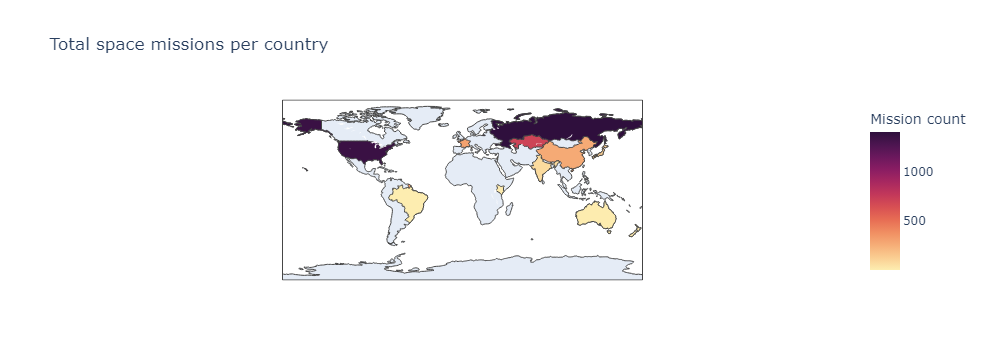

In [32]:
launch_per_country = df_data.groupby('country_code', as_index=False).agg({'Mission_Status': 'count'})
total_launch_map = px.choropleth(launch_per_country,
                      locations='country_code',
                      color='Mission_Status',
                      color_continuous_scale=px.colors.sequential.matter,
                      title = 'Total space missions per country',
                      labels={'Mission_Status':'Mission count'})
total_launch_map.show()

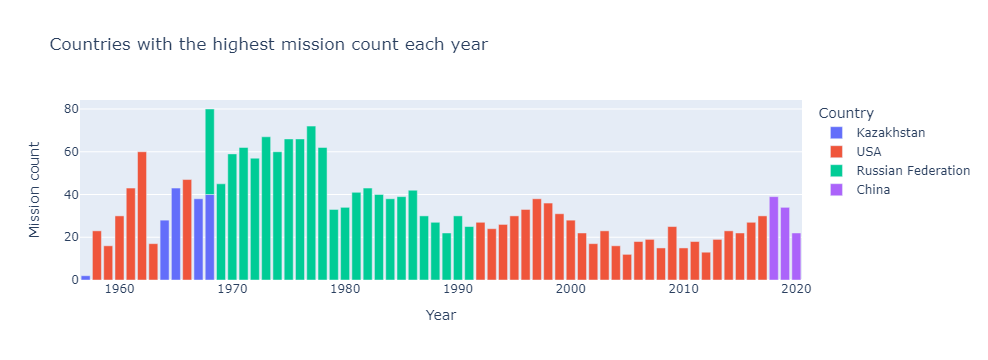

In [33]:
launch_per_country = df_data.groupby(['year','country'],as_index=False).agg({'Mission_Status':'count'}).sort_values(by=['year','Mission_Status'])
launch_top_country = launch_per_country.groupby('year',as_index=False).agg({'Mission_Status':'max'}).sort_values(by='year')
launch_top_country = launch_top_country.merge(launch_per_country,on=['year','Mission_Status'],how='left')
launch_top_country.head()
px.bar(launch_top_country,
       x='year',
       y='Mission_Status',
       color='country',
       title='Countries with the highest mission count each year',
       labels={'Mission_Status':'Mission count','year':'Year','country':'Country'})

In accordance with silent predictions, majority of missions were launched by USA and Russian Federation. The numbers of missions are split very similar to the organisation plots, showing how powerful the USSR space industry was back then, keeping the lead throughout 2 decades with numerous missions.

## Distribution of Mission Status

Having launched many missions does not necessarily equal having much success. While it is clear that not every mission in the history has been successful, it might be interesting to see if there are any patterns.

In [36]:
miss_effect = df_data.groupby('Mission_Status').agg({'Organisation':'count'}).sort_values(by='Organisation', ascending=False)
miss_effect.head(5)

Organisation
Mission_Status                 
Success                    3878
Failure                     339
Partial Failure             102
Prelaunch Failure             4

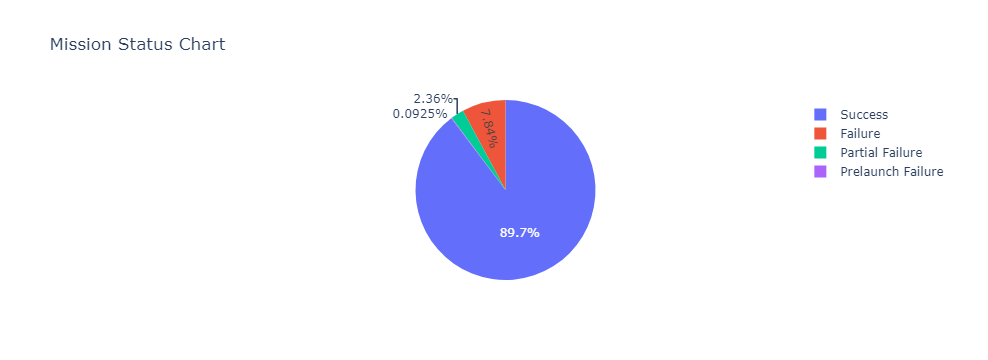

In [37]:
px.pie(miss_effect,
       names=miss_effect.index,
       values='Organisation',
       title='Mission Status Chart')

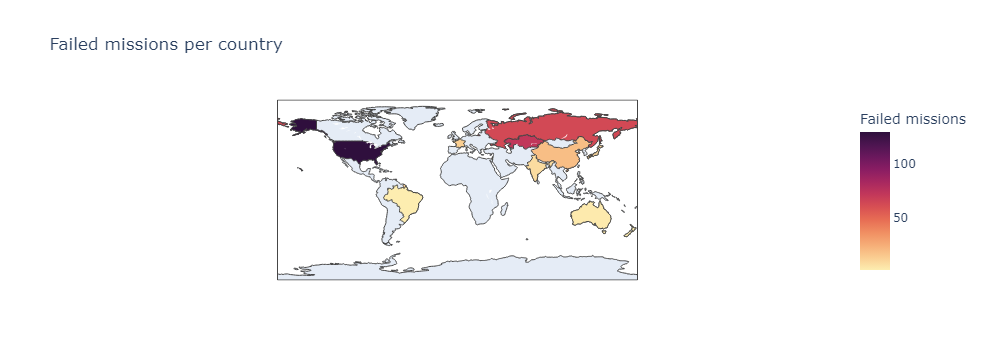

In [38]:
failures = df_data[df_data['Mission_Status']=='Failure'].groupby('country_code', as_index=False).agg({'Mission_Status': 'count'})
failure_map = px.choropleth(failures,
                      locations='country_code',
                      color='Mission_Status',
                      color_continuous_scale=px.colors.sequential.matter,
                      title='Failed missions per country',
                      labels={'Mission_Status':'Failed missions'})
failure_map.show()

Successful missions constitute almost 90% of total missions launched. That might be a relatively high success rate in such a difficult industry. If we treat Kazakhstan and Russian Federation as separate countries despite beign united as USSR, we can see that USA's failed mission count is a lot higher than other countries. But when did they occur?

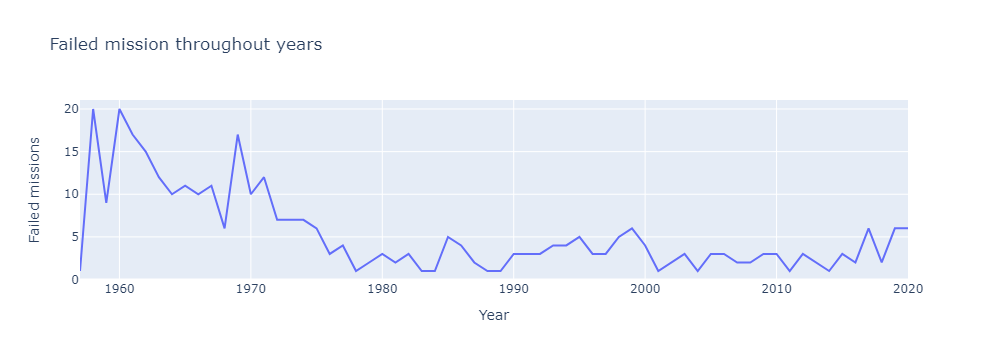

In [104]:
failures_per_year = df_data[df_data['Mission_Status']=='Failure'].groupby('year',as_index=False).agg({'Detail':'count'}).sort_values(by='year')
px.line(failures_per_year,
        x='year',
        y='Detail',
        title='Failed mission throughout years',
        labels={'Detail': 'Failed missions','year':'Year'})

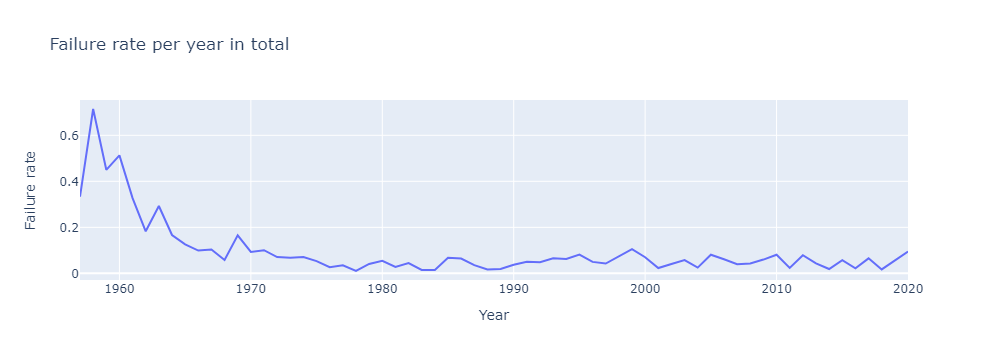

In [41]:
launch_per_year = df_data.groupby('year',as_index=False).agg({'Detail':'count'})
launch_per_year.sort_values(by='year',inplace=True)
fail_pct_year = failures_per_year['Detail']/launch_per_year['Detail']
px.line(fail_pct_year,
        x=failures_per_year.year,
        y=fail_pct_year.values,
        title='Failure rate per year in total',
        labels={'y':'Failure rate','x':'Year'})

Above graphs show that the failure nubmer and rate has settled down and pretty much stabilised since 1980s, having just a few failed missions per year worldwide. We could expect much better result though, knowing that space engineering and science keeps developing rapidly day by day.

Let's take a look at successful launches.

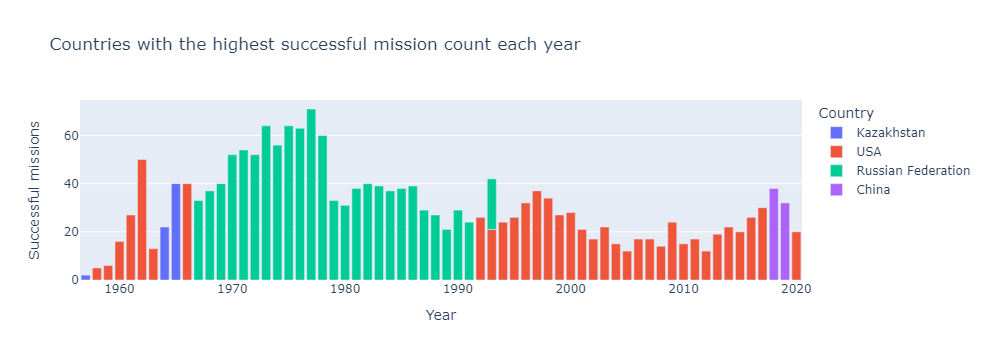

In [43]:
success_per_country = df_data[df_data['Mission_Status']=='Success'].groupby(['year','country'],as_index=False).agg({'Mission_Status':'count'}).sort_values(by=['year','Mission_Status'])
success_top_country = success_per_country.groupby('year',as_index=False).agg({'Mission_Status':'max'}).sort_values(by='year')
success_top_country = success_top_country.merge(success_per_country,on=['year','Mission_Status'],how='left')
px.bar(success_top_country,
       x='year',
       y='Mission_Status',
       color='country',
       title='Countries with the highest successful mission count each year',
       labels={'Mission_Status':'Successful missions','year':'Year','country':'Country'})

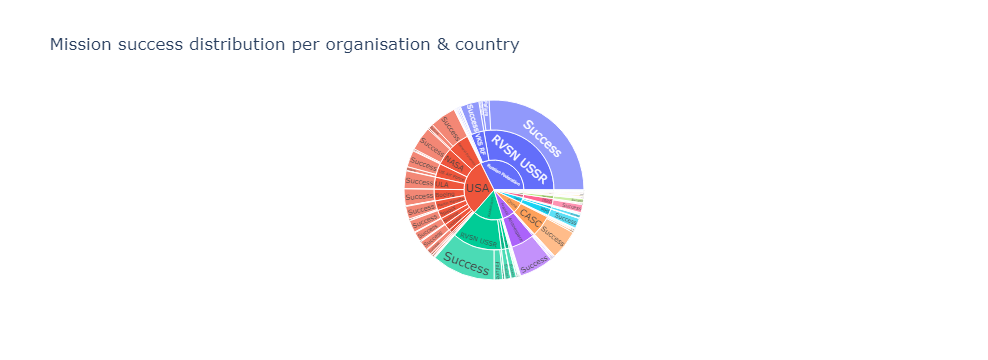

In [44]:
miss_effect_countries = df_data.groupby(['Organisation', 'country', 'Mission_Status'], as_index=False).size()
fig = px.sunburst(miss_effect_countries,
                  path=['country','Organisation','Mission_Status'],
                  values='size',
                  title='Mission success distribution per organisation & country')
fig.show()

# Pricing & Timing

Ever wondered how much does a space mission cost? Or how often does it take place? Let's dive into more charts.

## Money Spent by Organisation on Space Missions

In [47]:
cost_per_org = df_data.groupby('Organisation',as_index=False).agg({'Price':'sum'}).sort_values(by='Price',ascending=False)
cost_per_org.head()

Organisation     Price
35         NASA 76,280.00
3   Arianespace 16,345.00
48          ULA 14,798.00
40    RVSN USSR 10,000.00
7          CASC  6,310.51

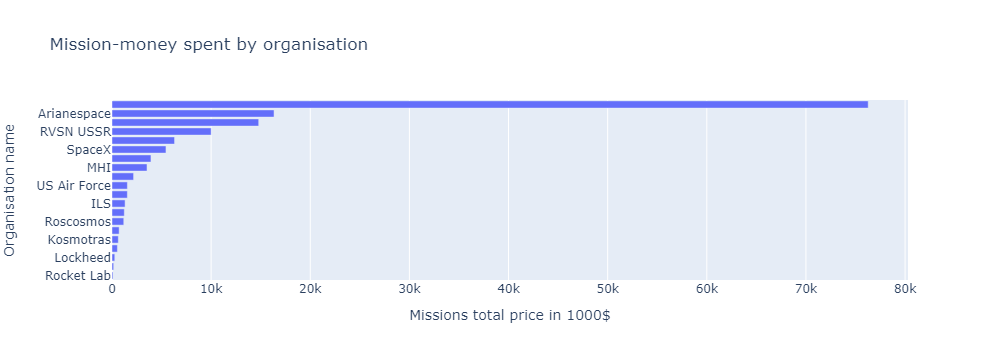

In [48]:
top20_cost_per_org = cost_per_org.nlargest(20,'Price')
bar = px.bar(x=top20_cost_per_org.Price,
       y=top20_cost_per_org.Organisation,
       orientation='h',
       title='Mission-money spent by organisation')
bar.update_layout(xaxis_title='Missions total price in 1000$',
                 yaxis_title='Organisation name',
                 yaxis={'categoryorder':'total ascending'})


In [49]:
launch_cost_per_org = df_data.groupby(['Organisation','Detail'],as_index=False).agg({'Price':'sum'}).sort_values(by='Price',ascending=False)
launch_cost_per_org.head()

Organisation                                  Detail    Price
2367    RVSN USSR  Energiya/Polyus | Polyus Space Station 5,000.00
2366    RVSN USSR                  Energiya/Buran | Buran 5,000.00
1547         NASA                     Saturn V | Skylab 1 1,160.00
1542         NASA                    Saturn V | Apollo 17 1,160.00
1535         NASA                    Saturn V | Apollo 10 1,160.00

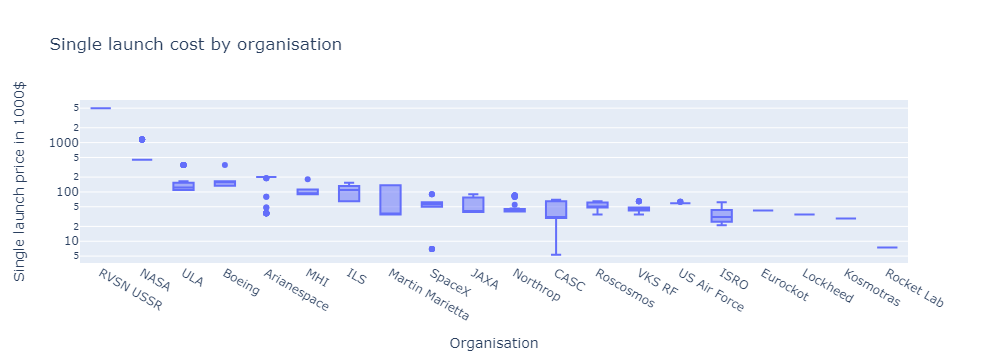

In [50]:
top_launch_cost_per_org = launch_cost_per_org.where(launch_cost_per_org['Organisation'].isin(top20_cost_per_org['Organisation']))
top_launch_cost_per_org = top_launch_cost_per_org.where(top_launch_cost_per_org['Price']>0)
bar = px.box(top_launch_cost_per_org,
             x='Organisation',
             y='Price',
             title='Single launch cost by organisation')
bar.update_layout(xaxis_title='Organisation',
                 yaxis_title='Single launch price in 1000$',
                #  yaxis={'categoryorder':'total ascending'},
                 yaxis=dict(type='log'))

It is really hard to make some observations about costs, because majority of the mission's prices are not provided. However, even with small amount of data, two leading organisations remain the same.

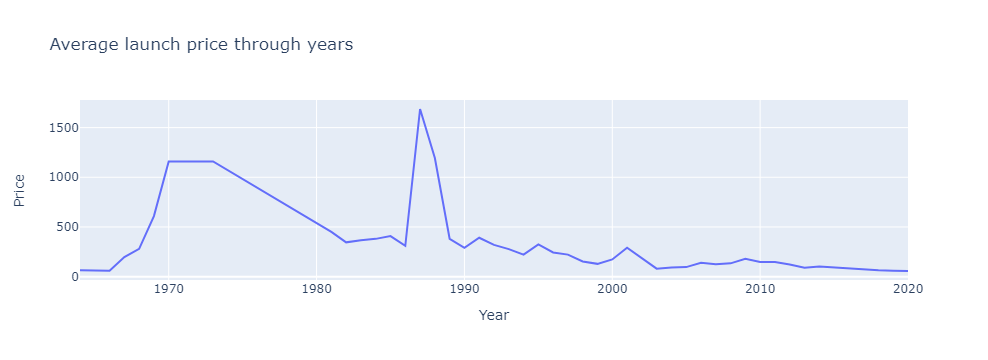

In [52]:
price_by_month_year = df_data[df_data['Price'] > 0].groupby('year',as_index=False).agg({'Price':'mean'})
px.line(price_by_month_year,
        x='year',
        y='Price',
        title='Average launch price through years',
        labels={'year':'Year'})

## Number of Launches per Year

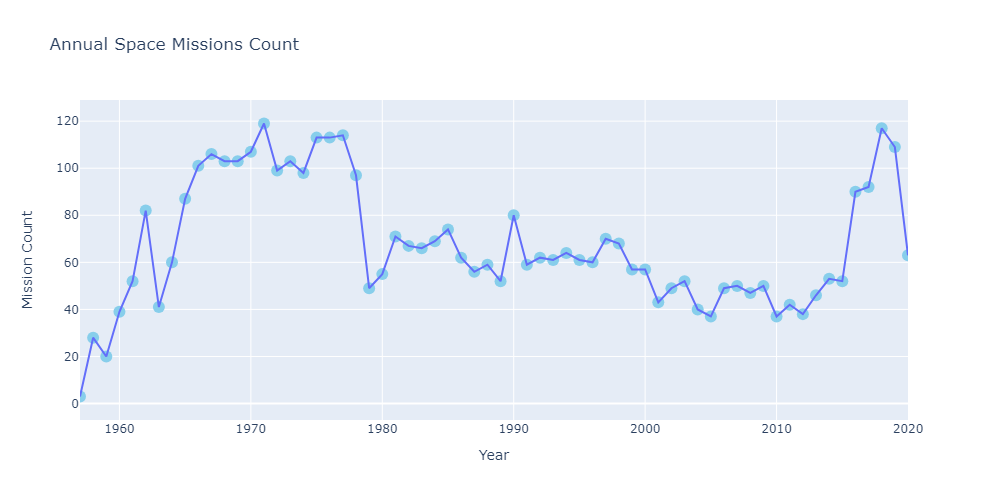

In [54]:
fig = px.scatter(launch_per_year,
                 x='year',
                 y='Detail',
                 title='Annual Space Missions Count',
                 labels={'Detail': 'Mission Count', 'year': 'Year'},
                 width=800, height=500,
                 size='Detail',
                 )
fig.update_traces(marker=dict(symbol='circle', size=12, color='skyblue'))
fig.update_layout(xaxis=dict(range=[1957, 2020]), yaxis=dict(range=[0, None]))

line_data = launch_per_year.groupby('year')['Detail'].sum().reset_index()
fig.add_trace(px.line(line_data, x='year', y='Detail').data[0])
fig.show()

There is a clear spike of launches count in the previous decade - it has nearly outnumbered the Cold war all-time high! It is surely linked to growing numbrs of Mars missions and also prime development time of companies like SpaceX.

## Best time of the year for mission

Which month has seen the highest number of launches in all time?

In [57]:
df_data['month_year'] = df_data['Date'].dt.strftime('%m-%Y')
launches_by_month = df_data.groupby('month_year').agg({'Detail':'count'})
max_month = launches_by_month['Detail'].idxmax()
print(f"All-time high mission count month: {max_month}")


All-time high mission count month: 12-1971


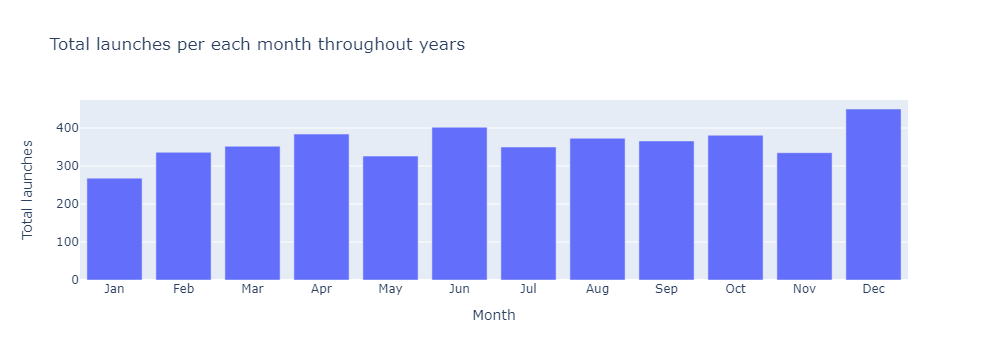

In [58]:
df_data['month'] = df_data['Date'].dt.month
launch_per_month = df_data.groupby('month', as_index=False).agg({'Detail':'count'})
launch_per_month['month_name'] = launch_per_month['month'].apply(lambda x: calendar.month_abbr[x])

px.bar(launch_per_month,
       x='month_name',
       y='Detail',
       title='Total launches per each month throughout years',
       labels={'Detail':'Total launches','month_name': 'Month'})

Depending on the location, some months may seem to be better for a launch and some may be worse, but surprisingly it's December that happens to be the most-chosen month for a space mission. The number of launches varies between 300-400 for majority of remaining months. It is quite impressive how mission times spread more evenly that one would think.

# Cold War Space Race: USA vs USSR

The cold war lasted from the start of the dataset up until 1991. Below chart presents the number of launches per each side during that time.
Russian Federation and Kazakhstan have been transformed into USSR to make the charts more readable and comparable.

## Comparing the total number of launches of the USSR and the USA


/tmp/ipykernel_478/2131521082.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



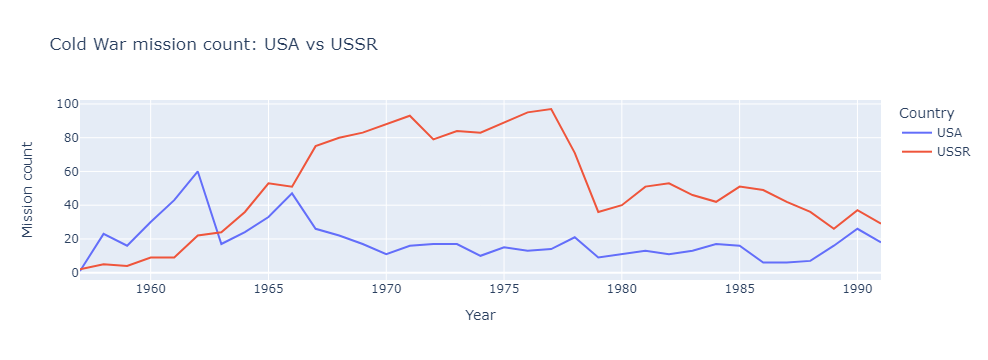

In [62]:
cold_war_countries = ['USA','Russian Federation','Kazakhstan']
cold_war_data = df_data.query('(country in @cold_war_countries) and year < 1992')
replace_dict_2 = {'Russian Federation':'USSR',
                  'Kazakhstan':'USSR'}
cold_war_data.country = cold_war_data.country.map(replace_dict_2).fillna(cold_war_data.country)
cold_war_launch_per_year = cold_war_data.groupby(['country','year'],as_index=False).agg({'Detail':'count'}).sort_values(by='year')
px.line(cold_war_launch_per_year,
        x='year',
        y='Detail',
        color='country',
        title = 'Cold War mission count: USA vs USSR',
        labels={'year':'Year','Detail':'Mission count','country':'Country'})

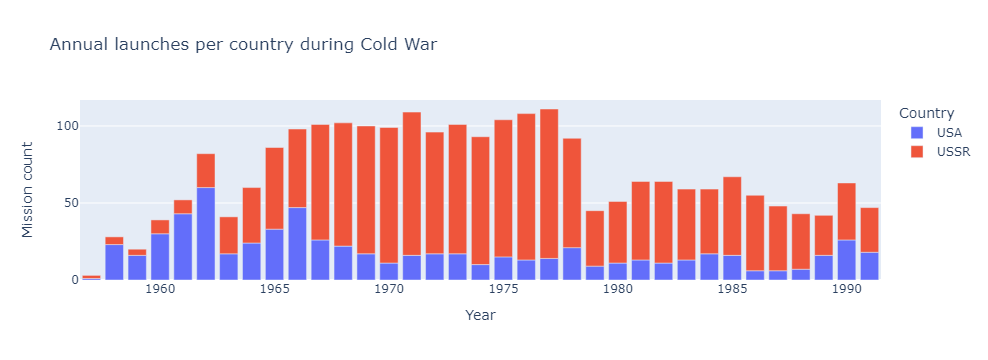

In [63]:
cold_war_launch_total_per_year = cold_war_data.groupby(['country','year'],as_index=False).agg({'Detail':'count'}).sort_values(by='year')
px.bar(cold_war_launch_total_per_year,
       x='year',
       y='Detail',
       color='country',
       title='Annual launches per country during Cold War',
       labels={'year':'Year','Detail':'Mission count','country':'Country'})

Above charts show strong predominance of USSR mission count during the Cold War. A significant peak is visible at roughly middle-time of the war, where the USSR's mission count is multiple times higher.

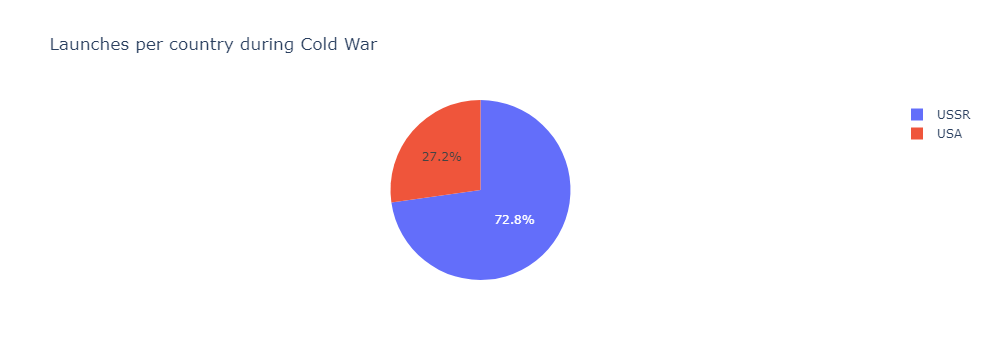

In [65]:
cold_war_launch_total =cold_war_data.groupby('country',as_index=False).agg({'Detail':'count'}).sort_values(by='country')
px.pie(cold_war_launch_total,
       names='country',
       values='Detail',
       title='Launches per country during Cold War')

# Conclusion

First thing to notice about the whole dataset, as represented by multiple charts, is the dominance of two countries or rather two sides - the USSR and USA. This dominanance does not only come from the fact, that the dataset is highly Cold War-oriented, but also because those countries - especially USA, have many space industry organisations that launch their own missions. It is not unusual to say more is more. Moreover, even without putting Kazakhstan and Russian Federation into USSR for analysis, the amount of launches per different organisations is high for both.



However, when we look at the choropleth map showing total number of launches up to 2020, countries like China or France also have surprisingly high amount of missions attempted - both around 300. In my opinion, it is especially France that has gone far beyond my predictions for this analysis, because who would expect a western european country to have so many missions launched already? Or is it because of the fact, that the first thing that comes to our mind for the keyword 'space mission' is actually the NASA and USA space industry? Worth a thought!

It is kind of a pity that the dataset contained so little amount of mission prices, making it pretty much impossible to create a reliable analysis for costs year by year, country by country, mission by mission. Nonetheless, the data that were provided, actually, have been used for analysis and proved how pricy the space industry is - and that, at least for me, is the only lack of surprise for this project.